# Financial Analytics of Stock Returns during Market Shock of Early 2022

### Import libraries and packages

In [287]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
import statsmodels.api as sm

# Step 1: Import and clean data

### Upload WRDS CRSP Data

In [288]:
returns = pd.read_csv('Project-2017-21-Returns.csv')
financial = pd.read_csv('Project-2021- Financials.csv')
sector = pd.read_csv('Project-2021-Sector.csv')

### Null Value Check

In [289]:
returns.isnull().sum()

PERMNO     0
date       0
TICKER    62
RET       15
dtype: int64

In [290]:
# Drop rows when 'TICKER' is Null
returns = returns.dropna(subset=['TICKER'])

### Examine varaibles in dataframe

In [291]:
returns.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114653 entries, 0 to 114714
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   PERMNO  114653 non-null  int64 
 1   date    114653 non-null  int64 
 2   TICKER  114653 non-null  object
 3   RET     114642 non-null  object
dtypes: int64(2), object(2)
memory usage: 4.4+ MB


In [292]:
# Convert 'RET' to a numeric format
# Cause we have 'C' and 'B' in RET columns,
# we will transform the non-numeric values into NaN.

returns['RET'] = pd.to_numeric(returns['RET'], errors='coerce')

In [293]:
# Check returns again
returns.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114653 entries, 0 to 114714
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   PERMNO  114653 non-null  int64  
 1   date    114653 non-null  int64  
 2   TICKER  114653 non-null  object 
 3   RET     114629 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 4.4+ MB


In [294]:
financial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1886 entries, 0 to 1885
Data columns (total 27 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   gvkey     1886 non-null   int64  
 1   datadate  1886 non-null   int64  
 2   fyear     1886 non-null   int64  
 3   indfmt    1886 non-null   object 
 4   consol    1886 non-null   object 
 5   popsrc    1886 non-null   object 
 6   datafmt   1886 non-null   object 
 7   tic       1886 non-null   object 
 8   curcd     1886 non-null   object 
 9   act       1431 non-null   float64
 10  at        1886 non-null   float64
 11  ceq       1886 non-null   float64
 12  csho      1886 non-null   float64
 13  dltt      1880 non-null   float64
 14  dt        1649 non-null   float64
 15  ebit      1886 non-null   float64
 16  ebitda    1770 non-null   float64
 17  icapt     1886 non-null   float64
 18  lct       1431 non-null   float64
 19  lt        1881 non-null   float64
 20  ni        1886 non-null   floa

In [295]:
sector.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1886 entries, 0 to 1885
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   gvkey     1886 non-null   int64 
 1   datadate  1886 non-null   int64 
 2   fyear     1886 non-null   int64 
 3   indfmt    1886 non-null   object
 4   consol    1886 non-null   object
 5   popsrc    1886 non-null   object
 6   datafmt   1886 non-null   object
 7   tic       1886 non-null   object
 8   curcd     1886 non-null   object
 9   costat    1886 non-null   object
 10  ggroup    1886 non-null   int64 
dtypes: int64(4), object(7)
memory usage: 162.2+ KB


# Step 2: Determine Risk Exposures

### List varaibles in FF dataframe

In [296]:
ff_factors = pd.read_csv('FF-Factors-2017-2021.csv')

In [297]:
ff_factors.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   dateff  60 non-null     int64  
 1   mktrf   60 non-null     float64
 2   smb     60 non-null     float64
 3   hml     60 non-null     float64
 4   rf      60 non-null     float64
dtypes: float64(4), int64(1)
memory usage: 2.5 KB


In [298]:
ff_factors.isnull().sum()

dateff    0
mktrf     0
smb       0
hml       0
rf        0
dtype: int64

### Rename date column to "date" to match WRDS data "date" column

In [299]:
ff_factors.rename(columns={'dateff':'date'}, inplace=True)

### Create a dataframe to store results

In [300]:
output_list = []

### Get 3000 TICKET and store in List

In [301]:
import sys
Ticket_List = []
with open('ProjectTickers.txt','r') as f:
 for line in f:
   Ticket_List.append(line.strip('\n'))
print(Ticket_List)

['A', 'AA', 'AAL', 'AAN', 'AAON', 'AAP', 'AAPL', 'AAT', 'AAWW', 'ABBV', 'ABC', 'ABCB', 'ABG', 'ABM', 'ABMD', 'ABR', 'ABT', 'ABTX', 'ABUS', 'ACAD', 'ACC', 'ACCO', 'ACGL', 'ACHC', 'ACIW', 'ACLS', 'ACM', 'ACN', 'ACRE', 'ACRS', 'ADBE', 'ADC', 'ADI', 'ADM', 'ADNT', 'ADP', 'ADSK', 'ADTN', 'ADUS', 'AEE', 'AEIS', 'AEL', 'AEO', 'AEP', 'AERI', 'AES', 'AFG', 'AFL', 'AGCO', 'AGEN', 'AGIO', 'AGLE', 'AGNC', 'AGO', 'AGR', 'AGX', 'AGYS', 'AHH', 'AHT', 'AIG', 'AIMC', 'AIN', 'AIR', 'AIT', 'AIV', 'AIZ', 'AJG', 'AJRD', 'AKAM', 'AKBA', 'AKR', 'AL', 'ALB', 'ALBO', 'ALDX', 'ALE', 'ALEX', 'ALG', 'ALGN', 'ALGT', 'ALK', 'ALKS', 'ALL', 'ALLE', 'ALLY', 'ALNY', 'ALRM', 'ALSN', 'ALX', 'AMAT', 'AMBA', 'AMBC', 'AMC', 'AMCX', 'AMD', 'AME', 'AMED', 'AMG', 'AMGN', 'AMH', 'AMKR', 'AMN', 'AMNB', 'AMOT', 'AMP', 'AMPE', 'AMPH', 'AMRC', 'AMRK', 'AMRS', 'AMSC', 'AMSF', 'AMSWA', 'AMT', 'AMTX', 'AMWD', 'AMZN', 'AN', 'ANAB', 'ANAT', 'ANDE', 'ANET', 'ANF', 'ANGO', 'ANIK', 'ANIP', 'ANSS', 'ANTM', 'AON', 'AOS', 'AOSL', 'APA', 'APAM

## Run an OLS regression for each stock (60 months) using FF 3-Factor model

In [302]:
for t in Ticket_List:
  T_data = returns[returns["TICKER"] == t]
  
  # Merge the data sets for WRDS data and Fama-French market data based on "date"
  T_ff = pd.merge(T_data, ff_factors, on='date', how='outer')
  
  # Run OLS regression for Stocks (60 months) using FF 3-factor model
  # [Ret(MSFT)-Rf] = alpha + B1(RetMkt-Rf) + b2(SMB) + b3(HML) + e
  
  #MSFT Regression for FF model
  y = T_ff["RET"] - T_ff["rf"]
  X = T_ff[['mktrf' , 'smb' , 'hml']] 
  # Use statsmodels
  X = sm.add_constant(X) # adding a constant
  model = sm.OLS(y, X).fit()
  # Store current stock data in to list
  T_list = [t, model.rsquared, model.rsquared_adj, model.params[0], model.params[1], model.params[2], model.params[3]]
  output_list.append(T_list)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [303]:
df = pd.DataFrame(output_list,columns=['TICKER','R-squared', 'Adj. R-squared', 
                                       'const', 'mktrf', 'smb', 'hml'],dtype=float)
df = df[['TICKER', 'mktrf', 'smb', 'hml']]
df

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  exec(code_obj, self.user_global_ns, self.user_ns)


,TICKER,mktrf,smb,hml
0,A,1.014152,-0.253674,-0.143608
1,AA,1.984149,0.527862,1.924844
2,AAL,1.315550,0.612825,1.248123
3,AAN,NaN,NaN,NaN
4,AAON,0.516779,0.422130,-0.117068
...,...,...,...,...
1881,ZEN,1.026803,1.363839,-0.774104
1882,ZION,1.084739,0.869374,1.151468
1883,ZNGA,0.101034,1.200987,-0.714916
1884,ZTS,0.728418,-0.560814,-0.179065


## Check for Missing Values

In [304]:
df.isnull().sum()

TICKER     0
mktrf     11
smb       11
hml       11
dtype: int64

In [305]:
# drop missing values
df = df.dropna()
df.isnull().sum()

TICKER    0
mktrf     0
smb       0
hml       0
dtype: int64

## Save output to csv file

In [306]:
df.to_csv('FF-Exposures.csv')

# Step 3:Calculate Financial Ratios

In [307]:
# Import 'ProjectTickers.csv' to get company names
tickers_data = pd.read_csv('ProjectTickers.csv')

In [308]:
comp_data = financial
comp_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1886 entries, 0 to 1885
Data columns (total 27 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   gvkey     1886 non-null   int64  
 1   datadate  1886 non-null   int64  
 2   fyear     1886 non-null   int64  
 3   indfmt    1886 non-null   object 
 4   consol    1886 non-null   object 
 5   popsrc    1886 non-null   object 
 6   datafmt   1886 non-null   object 
 7   tic       1886 non-null   object 
 8   curcd     1886 non-null   object 
 9   act       1431 non-null   float64
 10  at        1886 non-null   float64
 11  ceq       1886 non-null   float64
 12  csho      1886 non-null   float64
 13  dltt      1880 non-null   float64
 14  dt        1649 non-null   float64
 15  ebit      1886 non-null   float64
 16  ebitda    1770 non-null   float64
 17  icapt     1886 non-null   float64
 18  lct       1431 non-null   float64
 19  lt        1881 non-null   float64
 20  ni        1886 non-null   floa

In [309]:
tickers_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1886 entries, 0 to 1885
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ticker  1886 non-null   object 
 1   Name    1886 non-null   object 
 2   RetYTD  1886 non-null   float64
dtypes: float64(1), object(2)
memory usage: 44.3+ KB


## Data Cleaning

### Rename column name

In [310]:
comp_data.rename(columns = {"tic": "Ticker"},inplace=True)
comp_data.head()

,gvkey,datadate,fyear,indfmt,consol,popsrc,datafmt,Ticker,curcd,act,...,icapt,lct,lt,ni,re,sale,xad,costat,prcc_c,mkvalt
0,1004,20210531,2020,INDL,C,D,STD,AIR,USD,937.0,...,1168.000,336.800,565.300,35.80,723.400,1651.400,NaN,A,36.22,1476.9063
1,1045,20211231,2021,INDL,C,D,STD,AAL,USD,17336.0,...,34841.000,19006.000,73807.000,-1993.00,-14580.000,29882.000,105.0,A,17.96,11633.1949
2,1075,20211231,2021,INDL,C,D,STD,PNW,USD,1551.1,...,13663.596,1756.869,15981.762,618.72,3209.858,3803.835,NaN,A,70.59,7971.5169
3,1078,20211231,2021,INDL,C,D,STD,ABT,USD,24239.0,...,54276.000,13105.000,39172.000,7071.00,23154.000,43075.000,NaN,A,140.74,248276.9007
4,1161,20211231,2021,INDL,C,D,STD,AMD,USD,8583.0,...,7846.000,4240.000,4922.000,3162.00,-1454.000,16434.000,578.0,A,143.90,173687.3000


### Merge dataset

In [311]:
data = pd.merge(comp_data, tickers_data, how='left', on="Ticker")
data.head()

,gvkey,datadate,fyear,indfmt,consol,popsrc,datafmt,Ticker,curcd,act,...,lt,ni,re,sale,xad,costat,prcc_c,mkvalt,Name,RetYTD
0,1004,20210531,2020,INDL,C,D,STD,AIR,USD,937.0,...,565.300,35.80,723.400,1651.400,NaN,A,36.22,1476.9063,AAR Corp,0.2944
1,1045,20211231,2021,INDL,C,D,STD,AAL,USD,17336.0,...,73807.000,-1993.00,-14580.000,29882.000,105.0,A,17.96,11633.1949,American Airlines Gp,0.0579
2,1075,20211231,2021,INDL,C,D,STD,PNW,USD,1551.1,...,15981.762,618.72,3209.858,3803.835,NaN,A,70.59,7971.5169,Pinnacle West Capital Corp,0.0985
3,1078,20211231,2021,INDL,C,D,STD,ABT,USD,24239.0,...,39172.000,7071.00,23154.000,43075.000,NaN,A,140.74,248276.9007,Abbott Laboratories,-0.1638
4,1161,20211231,2021,INDL,C,D,STD,AMD,USD,8583.0,...,4922.000,3162.00,-1454.000,16434.000,578.0,A,143.90,173687.3000,Adv Micro Devices,-0.3533


## Preview Table

| Columns Name | Description                        |
|--------------|------------------------------------|
| gvkey        | Global Company Key                 |
| datadate     | Date                               |
| fyear        | Data Year - Fiscal                 |
| tic          | Ticker Symbol                      |
| act          | Current Assets - Total             |
| at           | Assets - Total                     |
| ceq          | Common/Ordinary Equity             |
| csho         | Common Shares Outstanding          |
| dltt         | Long-Term Debt - Total             |
| dt           | Total Debt Including Current       |
| ebit         | Earnings Before Interest and Taxes |
| ebitda       | Earnings Before Interest           |
| icapt        | Invested Capital - Total           |
| lct          | Current Liabilities - Total        |
| lt           | Liabilities - Total                |
| ni           | Net Income (Loss)                  |
| re           | Retained Earnings                  |
| sale         | Sales/Turnover (Net)               |
| xad          | Advertising Expense                |
| prcc_c       | Price Close - Annual - Calendar    |
| mkvalt       | Market Value - Total - Fiscal      |

## Check for Missing Values

In [312]:
data.isnull().sum()

gvkey          0
datadate       0
fyear          0
indfmt         0
consol         0
popsrc         0
datafmt        0
Ticker         0
curcd          0
act          455
at             0
ceq            0
csho           0
dltt           6
dt           237
ebit           0
ebitda       116
icapt          0
lct          455
lt             5
ni             0
re             3
sale           0
xad         1070
costat         0
prcc_c         0
mkvalt        19
Name           0
RetYTD         0
dtype: int64

In [313]:
# 'act','dt', 'xad', 'lct', 'ebitda' has too many null value, we will drop it
data = data.drop(columns=['act','dt', 'xad', 'lct', 'ebitda'])
data.isnull().sum()

gvkey        0
datadate     0
fyear        0
indfmt       0
consol       0
popsrc       0
datafmt      0
Ticker       0
curcd        0
at           0
ceq          0
csho         0
dltt         6
ebit         0
icapt        0
lt           5
ni           0
re           3
sale         0
costat       0
prcc_c       0
mkvalt      19
Name         0
RetYTD       0
dtype: int64

In [314]:
# 'dltt' means long term Debt, we can fill 0 if it's null
data['dltt'] = data['dltt'].fillna(0)

In [315]:
# 'mkvalt' = 'prcc_c'*'csho', we can fill na with calculation results
data['mkvalt'] = data['mkvalt'].fillna(data['prcc_c']*data['csho'])

In [316]:
# 'lt' means Liabilities - Total, we can fill 0 if it's null
data['lt'] = data['lt'].fillna(0)

In [317]:
# 'ebitda' means Retained Earnings, we can fill 0 if it's null
data['re'] = data['re'].fillna(0)

In [318]:
data.isnull().sum()

gvkey       0
datadate    0
fyear       0
indfmt      0
consol      0
popsrc      0
datafmt     0
Ticker      0
curcd       0
at          0
ceq         0
csho        0
dltt        0
ebit        0
icapt       0
lt          0
ni          0
re          0
sale        0
costat      0
prcc_c      0
mkvalt      0
Name        0
RetYTD      0
dtype: int64

Now we clean up the data and there are no null values

## Calculate Market Ratio

### Market Ratios

In [319]:
data['Price/Book'] = data['mkvalt']/data['ceq']

In [320]:
data['Book/Price'] = 1/data['Price/Book']

In [321]:
data['P/E'] = data['mkvalt']/data['ni']

In [322]:
data['E/P'] = 1/data['P/E']

In [323]:
data['P/EBIT'] = data['mkvalt']/data['ebit']

In [324]:
data['EBIT/P'] = 1/data['P/EBIT']

In [325]:
data['P/SALES'] = data['mkvalt']/data['sale']

In [326]:
data['SALES/P'] = 1/data['P/SALES']

### Adding finaical variables

In [327]:
data['Total assets turnover'] = data['sale'] / data['at']

In [328]:
data['LT_Debit/Total_assets'] = data['dltt']/data['at']

In [329]:
data['ROA'] = data['ebit']/data['at']

In [330]:
data['RE/Total_Assets'] = data['re'] / data['at']

In [331]:
data['NET PROFIT MARGIN'] = data['ebit'] / data['sale']

In [332]:
data['Market_Value/Book_Equity'] = data['mkvalt'] / data['ceq']

### Select useful column for modeling

In [333]:
output_data = data[['Ticker',
                    'Book/Price', 
                    'E/P', 
                    'EBIT/P', 
                    'SALES/P',
                    'Total assets turnover',
                    'LT_Debit/Total_assets',
                    'ROA',
                    'RE/Total_Assets',
                    'NET PROFIT MARGIN',
                    'Market_Value/Book_Equity']]

## Check for Missing Values, Outliers and Data Errors

### Check Missing Value

In [334]:
output_data.isnull().sum()

Ticker                      0
Book/Price                  0
E/P                         0
EBIT/P                      0
SALES/P                     0
Total assets turnover       0
LT_Debit/Total_assets       0
ROA                         0
RE/Total_Assets             0
NET PROFIT MARGIN           0
Market_Value/Book_Equity    0
dtype: int64

## Check and fix Outliers

### Book/Price

count    1886.000000
mean        0.419463
std         0.420559
min        -2.056645
25%         0.160357
50%         0.337783
75%         0.608627
max         7.547555
Name: Book/Price, dtype: float64


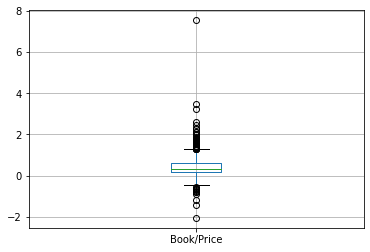

In [335]:
print(output_data['Book/Price'].describe())
output_data.boxplot(column='Book/Price')

We will use Winsorize Method to limit outliers with an upper and lower limit.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


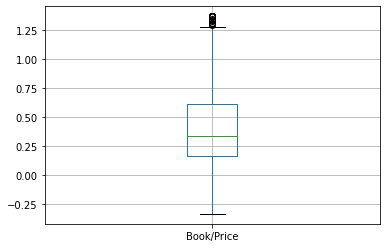

In [336]:
output_data['Book/Price'] = winsorize(output_data['Book/Price'], (0.01, 0.02))
output_data.boxplot(column='Book/Price')

### E/P

count    1886.000000
mean        0.028362
std         0.132475
min        -1.361014
25%         0.008159
50%         0.036775
75%         0.075836
max         1.266928
Name: E/P, dtype: float64


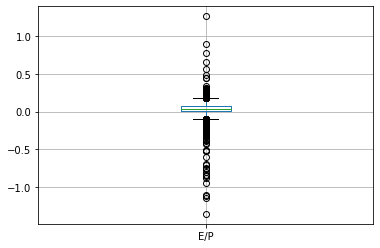

In [337]:
print(output_data['E/P'].describe())
output_data.boxplot(column='E/P')

We will use Winsorize Method to limit outliers with an upper and lower limit.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


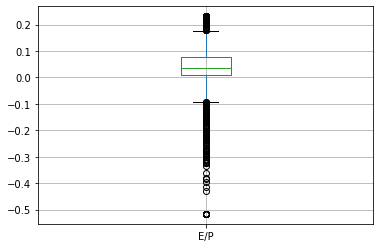

In [338]:
output_data['E/P'] = winsorize(output_data['E/P'], (0.01, 0.02))
output_data.boxplot(column='E/P')

### EBIT/P

count    1886.000000
mean        0.061408
std         0.128019
min        -1.034530
25%         0.019405
50%         0.056386
75%         0.113710
max         0.974888
Name: EBIT/P, dtype: float64


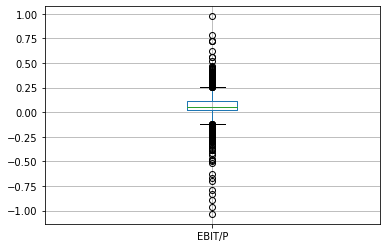

In [339]:
print(output_data['EBIT/P'].describe())
output_data.boxplot(column='EBIT/P')

We will use Winsorize Method to limit outliers with an upper and lower limit.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


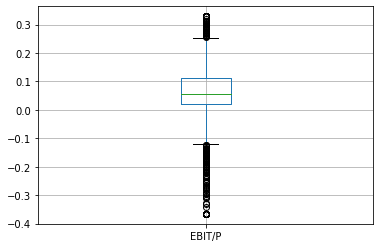

In [340]:
output_data['EBIT/P'] = winsorize(output_data['EBIT/P'], (0.01, 0.02))
output_data.boxplot(column='EBIT/P')

### SALES/P

count    1886.000000
mean        0.756090
std         1.408077
min        -0.087004
25%         0.179004
50%         0.352446
75%         0.812176
max        22.268447
Name: SALES/P, dtype: float64


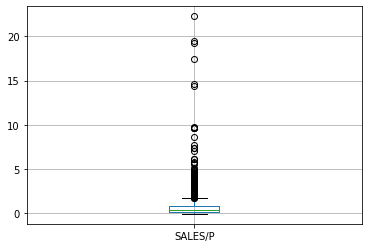

In [341]:
print(output_data['SALES/P'].describe())
output_data.boxplot(column='SALES/P')

We will use Winsorize Method to limit outliers with an upper and lower limit.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


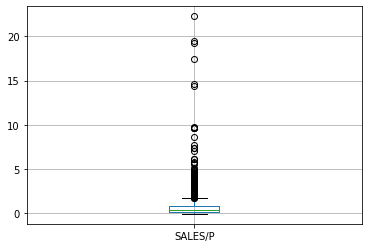

In [342]:
output_data['SALES/PS'] = winsorize(output_data['SALES/P'], (0.01, 0.02))
output_data.boxplot(column='SALES/P')

### Total assets turnover

count    1886.000000
mean        0.642005
std         0.616868
min        -0.009803
25%         0.185607
50%         0.511923
75%         0.900111
max         6.389003
Name: Total assets turnover, dtype: float64


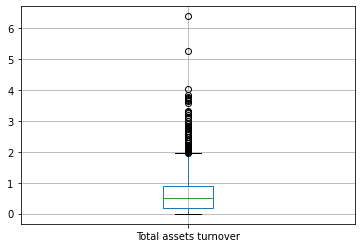

In [343]:
print(output_data['Total assets turnover'].describe())
output_data.boxplot(column='Total assets turnover')

We will use Winsorize Method to limit outliers with an upper and lower limit.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


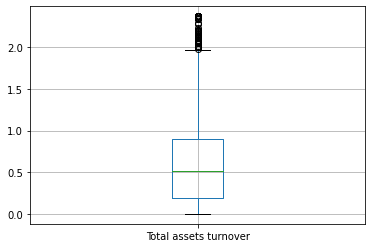

In [344]:
output_data['Total assets turnover'] = winsorize(output_data['Total assets turnover'], (0.01, 0.02))
output_data.boxplot(column='Total assets turnover')

### LT_Debit/Total_assets

count    1886.000000
mean        0.280539
std         0.244616
min         0.000000
25%         0.078514
50%         0.256766
75%         0.407980
max         3.109857
Name: LT_Debit/Total_assets, dtype: float64


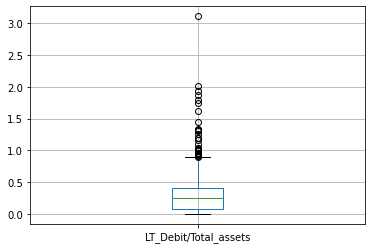

In [345]:
print(output_data['LT_Debit/Total_assets'].describe())
output_data.boxplot(column='LT_Debit/Total_assets')

For 'LT_Debit/Total_assets', we do not need to deal with outliners

### ROA  

count    1886.000000
mean        0.047180
std         0.157399
min        -1.420596
25%         0.018602
50%         0.053231
75%         0.106175
max         1.908472
Name: ROA, dtype: float64


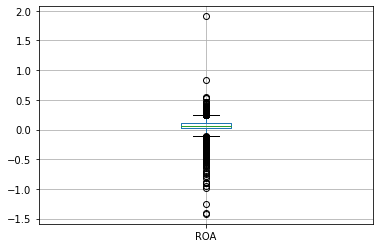

In [346]:
print(output_data['ROA'].describe())
output_data.boxplot(column='ROA')

We will use Winsorize Method to limit outliers with an upper and lower limit.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


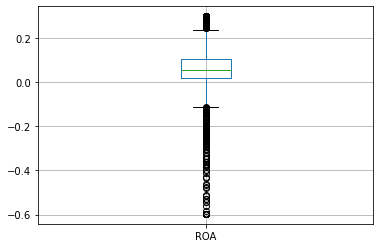

In [347]:
output_data['ROA'] = winsorize(output_data['ROA'], (0.01, 0.02))
output_data.boxplot(column='ROA')

### RE/Total_Assets

count    1886.000000
mean       -0.096974
std         1.315257
min       -35.382839
25%        -0.083876
50%         0.084603
75%         0.313861
max         2.484373
Name: RE/Total_Assets, dtype: float64


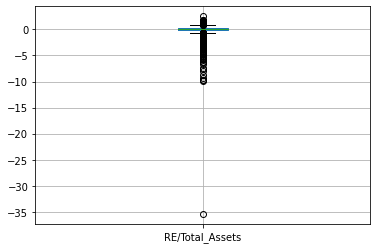

In [348]:
print(output_data['RE/Total_Assets'].describe())
output_data.boxplot(column='RE/Total_Assets')

RE/Total_Assets do not represent outliner conditions and therefore do nothing

### NET PROFIT MARGIN

count    1886.000000
mean            -inf
std              NaN
min             -inf
25%         0.045584
50%         0.127945
75%         0.265951
max         1.220085
Name: NET PROFIT MARGIN, dtype: float64


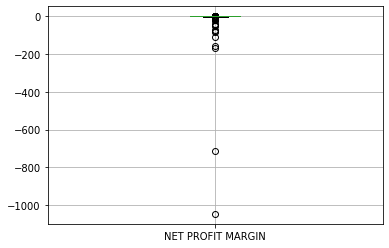

In [349]:
print(output_data['NET PROFIT MARGIN'].describe())
output_data.boxplot(column='NET PROFIT MARGIN')

We will use Winsorize Method to limit outliers with an upper and lower limit.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


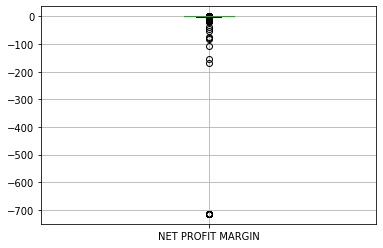

In [350]:
output_data['NET PROFIT MARGIN'] = winsorize(output_data['NET PROFIT MARGIN'], (0.01, 0.02))
output_data.boxplot(column='NET PROFIT MARGIN')

### Market_Value/Book_Equity

count    1886.000000
mean        2.701185
std        90.419780
min     -2551.948309
25%         1.460857
50%         2.678204
75%         5.244947
max      1961.807510
Name: Market_Value/Book_Equity, dtype: float64


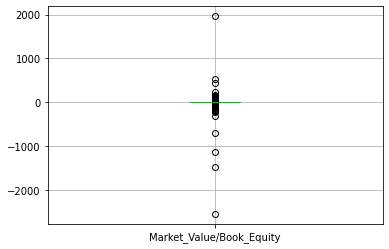

In [351]:
print(output_data['Market_Value/Book_Equity'].describe())
output_data.boxplot(column='Market_Value/Book_Equity')

We will use Winsorize Method to limit outliers with an upper and lower limit.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


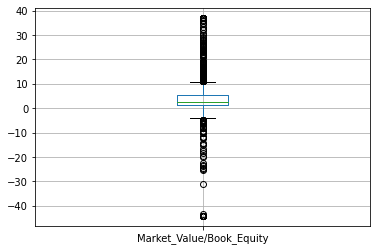

In [352]:
output_data['Market_Value/Book_Equity'] = winsorize(output_data['Market_Value/Book_Equity'], (0.01, 0.02))
output_data.boxplot(column='Market_Value/Book_Equity')

## Save output to csv file

In [353]:
output_data.to_csv('Fin-Ratios.csv')

# Step 4: Industry Indicators

In [354]:
# Upload CSV file from your local machine to working directory in Colab
ProjectTickers = pd.read_csv('ProjectTickers.csv')
GICS = pd.read_csv('GICS_Code.csv')

In [355]:
ProjectTickers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1886 entries, 0 to 1885
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ticker  1886 non-null   object 
 1   Name    1886 non-null   object 
 2   RetYTD  1886 non-null   float64
dtypes: float64(1), object(2)
memory usage: 44.3+ KB


In [356]:
GICS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ggroup    24 non-null     int64 
 1   Industry  24 non-null     object
dtypes: int64(1), object(1)
memory usage: 512.0+ bytes


In [357]:
df = ProjectTickers.merge(sector,left_on='Ticker',right_on='tic',how='left')
df = df.merge(GICS,on='ggroup',how='left')
df = df[['Ticker', 'Name ', 'RetYTD', 'ggroup', 'Industry']]

In [358]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1886 entries, 0 to 1885
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Ticker    1886 non-null   object 
 1   Name      1886 non-null   object 
 2   RetYTD    1886 non-null   float64
 3   ggroup    1886 non-null   int64  
 4   Industry  1844 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 88.4+ KB


In [359]:
df.to_csv('Industry.csv')

# Step 5: Run OLS explanatory for 4 categories

## Risk Regressions

In [360]:
ProjectTickers = pd.read_csv('ProjectTickers.csv')

In [361]:
ProjectTickers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1886 entries, 0 to 1885
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ticker  1886 non-null   object 
 1   Name    1886 non-null   object 
 2   RetYTD  1886 non-null   float64
dtypes: float64(1), object(2)
memory usage: 44.3+ KB


In [362]:
ff_data = pd.read_csv('FF-Exposures.csv')

In [363]:
ff_data.info()
ff_data = ff_data.drop(columns = 'Unnamed: 0')
ff_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1875 entries, 0 to 1874
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1875 non-null   int64  
 1   TICKER      1875 non-null   object 
 2   mktrf       1875 non-null   float64
 3   smb         1875 non-null   float64
 4   hml         1875 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 73.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1875 entries, 0 to 1874
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TICKER  1875 non-null   object 
 1   mktrf   1875 non-null   float64
 2   smb     1875 non-null   float64
 3   hml     1875 non-null   float64
dtypes: float64(3), object(1)
memory usage: 58.7+ KB


In [364]:
Risk_data = ProjectTickers.merge(ff_data,left_on='Ticker',right_on='TICKER',how='left')

Risk_data

,Ticker,Name,RetYTD,TICKER,mktrf,smb,hml
0,A,Agilent Technologies,-0.2080,A,1.014152,-0.253674,-0.143608
1,AA,Alcoa Corp,0.4731,AA,1.984149,0.527862,1.924844
2,AAL,American Airlines Gp,0.0579,AAL,1.315550,0.612825,1.248123
3,AAN,Aarons Holdings Company,-0.1327,NaN,NaN,NaN,NaN
4,AAON,Aaon Inc,-0.3456,AAON,0.516779,0.422130,-0.117068
...,...,...,...,...,...,...,...
1881,ZEN,Zendesk Inc,0.2002,ZEN,1.026803,1.363839,-0.774104
1882,ZION,Zions Bancorp,-0.0038,ZION,1.084739,0.869374,1.151468
1883,ZNGA,Zynga Inc Cl A,0.3969,ZNGA,0.101034,1.200987,-0.714916
1884,ZTS,Zoetis Inc Cl A,-0.2325,ZTS,0.728418,-0.560814,-0.179065


### Check Missing Values after merging

In [365]:
Risk_data.isnull().sum()

Ticker     0
Name       0
RetYTD     0
TICKER    11
mktrf     11
smb       11
hml       11
dtype: int64

In [366]:
# Drop missing values
Risk_data = Risk_data.dropna()
Risk_data.isnull().sum()

Ticker    0
Name      0
RetYTD    0
TICKER    0
mktrf     0
smb       0
hml       0
dtype: int64

### Check Outliner

#### mktrf

count    1875.000000
mean        1.063239
std         0.623565
min        -6.676723
25%         0.719835
50%         1.004945
75%         1.333367
max         6.002016
Name: mktrf, dtype: float64


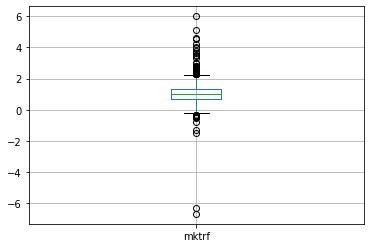

In [367]:
print(Risk_data['mktrf'].describe())
Risk_data.boxplot(column='mktrf')

We will use Winsorize Method to limit outliers with an upper and lower limit.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


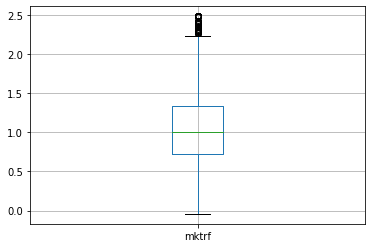

In [368]:
Risk_data['mktrf'] = winsorize(Risk_data['mktrf'], (0.01, 0.02))
Risk_data.boxplot(column='mktrf')

#### smb

count    1875.000000
mean        0.668200
std         1.234872
min        -6.286219
25%         0.014386
50%         0.503529
75%         1.021098
max        31.005941
Name: smb, dtype: float64


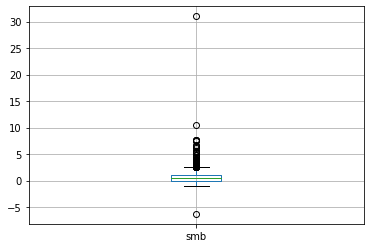

In [369]:
print(Risk_data['smb'].describe())
Risk_data.boxplot(column='smb')

We will use Winsorize Method to limit outliers with an upper and lower limit.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


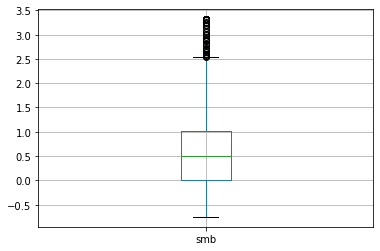

In [370]:
Risk_data['smb'] = winsorize(Risk_data['smb'], (0.01, 0.02))
Risk_data.boxplot(column='smb')

#### hml

count    1875.000000
mean        0.315612
std         0.700322
min        -3.593321
25%        -0.050644
50%         0.355607
75%         0.759826
max         5.919490
Name: hml, dtype: float64


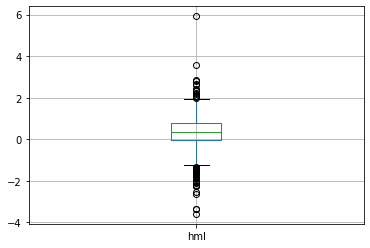

In [371]:
print(Risk_data['hml'].describe())
Risk_data.boxplot(column='hml')

We will use Winsorize Method to limit outliers with an upper and lower limit.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


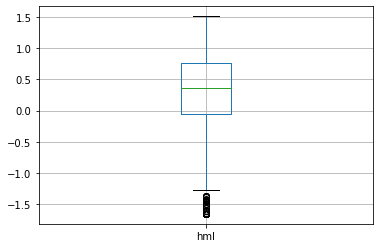

In [372]:
Risk_data['hml'] = winsorize(Risk_data['hml'], (0.01, 0.02))
Risk_data.boxplot(column='hml')

### Run OLS Model

In [373]:
# define x as a subset of original dataframe
x = Risk_data[['mktrf' , 'smb' , 'hml']] 
x['constant'] = 1
# define y as a series
y = Risk_data["RetYTD"]

# pass x as a dataframe, while pass y as a series
sm.OLS(y, x).fit().summary()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 RetYTD   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     63.15
Date:                Thu, 28 Apr 2022   Prob (F-statistic):           6.87e-39
Time:                        14:12:38   Log-Likelihood:                 73.410
No. Observations:                1875   AIC:                            -138.8
Df Residuals:                    1871   BIC:                            -116.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
mktrf         -0.0072      0.011     -0.650      0.516      -0.029       0.015
smb           -0.0068      0.007     -1.040      0.298      -0.020       0.006
hml            0.1156      0.008     13.668      0.000       0.099       0.132
constant      -0.0870      0.013     -6.937      0.000      -0.112      -0.062
==============================================================================
Omnibus:                      646.328   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3535.034
Skew:                           1.522   Prob(JB):                         0.00
Kurtosis:                       8.999   Cond. No.                         5.12
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* R2 and Adj.R2

> After treating the outliner, R2 does not improve, R2 and adj.R2 are 0.09 and 0.089 respectively.This is not a very good result, which indicates that the dependent variable is not explaining much in the variation of independent variable.



* Coefficients

> The coefficient of 'SMB' is negative, which means small stocks do worse than large stocks. The coefficient of "HML" is positive, which means that high value stocks do well relative to low value stocks. The coefficient of 'MKTRF' is negative, which means that the higher the asset's systematic risk, the lower the 'RetYTD '. In general, this is consistent with the reality. In the event of market fluctuations and unforeseen factors, large stocks with high value have a stronger ability to resist risks, so as to obtain better 'RetYTD '.


## Financial Characteristics

In [374]:
ProjectTickers = pd.read_csv('ProjectTickers.csv')

In [375]:
ProjectTickers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1886 entries, 0 to 1885
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ticker  1886 non-null   object 
 1   Name    1886 non-null   object 
 2   RetYTD  1886 non-null   float64
dtypes: float64(1), object(2)
memory usage: 44.3+ KB


In [376]:
Ratios = pd.read_csv('Fin-Ratios.csv')

In [377]:
Ratios.info()
Ratios = Ratios.drop(columns = 'Unnamed: 0')
Ratios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1886 entries, 0 to 1885
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                1886 non-null   int64  
 1   Ticker                    1886 non-null   object 
 2   Book/Price                1886 non-null   float64
 3   E/P                       1886 non-null   float64
 4   EBIT/P                    1886 non-null   float64
 5   SALES/P                   1886 non-null   float64
 6   Total assets turnover     1886 non-null   float64
 7   LT_Debit/Total_assets     1886 non-null   float64
 8   ROA                       1886 non-null   float64
 9   RE/Total_Assets           1886 non-null   float64
 10  NET PROFIT MARGIN         1886 non-null   float64
 11  Market_Value/Book_Equity  1886 non-null   float64
 12  SALES/PS                  1886 non-null   float64
dtypes: float64(11), int64(1), object(1)
memory usage: 191.7+ KB
<cl

In [378]:
Financial_data = ProjectTickers.merge(Ratios, on='Ticker',how='left')

Financial_data.head()

,Ticker,Name,RetYTD,Book/Price,E/P,EBIT/P,SALES/P,Total assets turnover,LT_Debit/Total_assets,ROA,RE/Total_Assets,NET PROFIT MARGIN,Market_Value/Book_Equity,SALES/PS
0,A,Agilent Technologies,-0.2080,0.113227,0.025423,0.029604,0.132767,0.590285,0.267071,0.131621,0.006165,0.222978,8.831831,0.132767
1,AA,Alcoa Corp,0.4731,0.425940,0.039111,0.189357,1.107882,0.808785,0.119135,0.138236,-0.326589,0.170918,2.347748,1.107882
2,AAL,American Airlines Gp,0.0579,-0.337273,-0.171320,-0.365760,2.568684,0.449576,0.634616,-0.082958,-0.219357,-0.184526,-1.584904,2.568684
3,AAN,Aarons Holdings Company,-0.1327,0.940491,0.143967,0.206699,2.416822,1.280475,0.214974,0.109513,0.067862,0.085525,1.063275,2.416822
4,AAON,Aaon Inc,-0.3456,0.111730,0.014083,0.017648,0.128111,0.822106,0.085310,0.113249,0.591076,0.137754,8.950166,0.128111


### Check Missing Values after merging

In [379]:
Financial_data.isnull().sum()

Ticker                      0
Name                        0
RetYTD                      0
Book/Price                  0
E/P                         0
EBIT/P                      0
SALES/P                     0
Total assets turnover       0
LT_Debit/Total_assets       0
ROA                         0
RE/Total_Assets             0
NET PROFIT MARGIN           0
Market_Value/Book_Equity    0
SALES/PS                    0
dtype: int64

### Run OLS Model

In [380]:
# define x as a subset of original dataframe
x = Financial_data.drop(columns = ['Ticker', 'Name ', 'RetYTD'])
x['constant'] = 1
# define y as a series
y = Financial_data["RetYTD"]

# pass x as a dataframe, while pass y as a series
sm.OLS(y, x).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 RetYTD   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     22.22
Date:                Thu, 28 Apr 2022   Prob (F-statistic):           3.61e-43
Time:                        14:12:39   Log-Likelihood:                 101.92
No. Observations:                1886   AIC:                            -179.8
Df Residuals:                    1874   BIC:                            -113.3
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Book/Price                   0.1801      0.022      8.244      0.000       0.137       0.223
E/P                         -0.1768      0.094     -1.876      0.061      -0.362       0.008
EBIT/P                      -0.1098      0.099     -1.107      0.268      -0.304       0.085
SALES/P                      0.0158      0.006      2.437      0.015       0.003       0.029
Total assets turnover       -0.0564      0.017     -3.410      0.001      -0.089      -0.024
LT_Debit/Total_assets        0.1322      0.024      5.407      0.000       0.084       0.180
ROA                          0.4399      0.070      6.271      0.000       0.302       0.577
RE/Total_Assets              0.0024      0.005      0.497      0.619      -0.007       0.012
NET PROFIT MARGIN           -0.0002   7.92e-05     -2.394      0.017      -0.000   -3.43e-05
Market_Value/Book_Equity    -0.0009      0.001     -1.449      0.147      -0.002       0.000
SALES/PS                     0.0224      0.014      1.630      0.103      -0.005       0.049
constant                    -0.1727      0.017     -9.981      0.000      -0.207      -0.139
==============================================================================
Omnibus:                      636.996   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4059.860
Skew:                           1.435   Prob(JB):                         0.00
Kurtosis:                       9.590   Cond. No.                     1.71e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.71e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

* R2 and Adj.R2

> By modifying the ratio several times and calculating the market ratio as the reciprocal, we end up with R2 = 0.116, adj. R2 = 0.110. This is not a very good model, but it is much better than Risk Exposures. In terms of statistical significance the dependent variable is not explaining much in the variation of independent variable. but considering that there are too many dependent variables and also half of the p-values are greater than 0.05. this means that half of the variables are statistically There is no significance.



* Coefficients

> 'RetYTD' has a positive relationship with Book/Price, SALES/P, LT_Debit/Total_assets, ROA, RE/Total_Assets, and SALES/PS. It is inversely proportional to E/P, EBIT/P, Total assets turnover, NET PROFIT MARGIN, and Market_Value/Book_Equity.


## Industry Dummies

In [381]:
# Upload CSV file from your local machine to working directory in Colab
Industry = pd.read_csv('Industry.csv')

In [382]:
Industry.info()
Industry = Industry.drop(columns='Unnamed: 0')
Industry.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1886 entries, 0 to 1885
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1886 non-null   int64  
 1   Ticker      1886 non-null   object 
 2   Name        1886 non-null   object 
 3   RetYTD      1886 non-null   float64
 4   ggroup      1886 non-null   int64  
 5   Industry    1844 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 88.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1886 entries, 0 to 1885
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Ticker    1886 non-null   object 
 1   Name      1886 non-null   object 
 2   RetYTD    1886 non-null   float64
 3   ggroup    1886 non-null   int64  
 4   Industry  1844 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 73.8+ KB


### Check Missing Value

In [383]:
Industry.isnull().sum()

Ticker       0
Name         0
RetYTD       0
ggroup       0
Industry    42
dtype: int64

In [384]:
Industry = Industry.dropna()
Industry.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1844 entries, 0 to 1885
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Ticker    1844 non-null   object 
 1   Name      1844 non-null   object 
 2   RetYTD    1844 non-null   float64
 3   ggroup    1844 non-null   int64  
 4   Industry  1844 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 86.4+ KB


In [385]:
av_Ret = Industry.groupby('ggroup').mean('RetYTD').sort_values('RetYTD',ascending=True)
av_Ret = av_Ret.merge(GICS,on='ggroup',how='left')
av_Ret

,ggroup,RetYTD,Industry
0,4530,-0.252813,Semiconductors & Semiconductor Equipment
1,2520,-0.208598,Consumer Durables & Apparel
2,2510,-0.207992,Automobiles & Components
3,4520,-0.172065,Technology Hardware & Equipment
4,3520,-0.163937,"Pharmaceuticals, Biotechnology & Life Sciences"
5,3030,-0.153771,Household & Personal Products
6,2550,-0.151223,Retailing
7,4020,-0.122515,Diversified Financials
8,4510,-0.108644,Software & Services
9,2010,-0.090548,Capital Goods


The industry with the highest return is 'Energy' and the lowest return is 'Semiconductors & Semiconductor Equipment'. I will analyze the following in the context of global political and economic activities in early 2022.
First, the climb in energy returns is due to market supply and demand. Russia's energy exports are critical to the European, and indeed global, energy market. Russia accounts for 11.6 percent of global oil exports, 15 percent of global coal exports, and 19.9 percent of global natural gas exports. The sudden crisis in Ukraine in 2022, however, led to sanctions on Russian energy exports. This directly led to a plunge in energy supply to the market, where the supply was less than the demand and energy prices soared in a short time.

Ukraine serves as an important global base for neon processing, and Russia produces a lot of neon then sends it to Ukraine, where the neon is extracted and purified for export. and some of the world's major semiconductor manufacturing companies depend almost entirely on Some of the world's major semiconductor manufacturers depend almost entirely on this supply chain. For semiconductor orders are usually created in large quantities by various communication manufacturers to semiconductor manufacturers, and the prices are agreed upon at the time of order creation. The sudden shortage of neon has led to a steep rise in raw material costs for chip manufacturers, ultimately leading to a significant reduction in profits.

Reference:
https://www.msci.com/our-solutions/indexes/gics
https://www.euractiv.com/section/digital/news/ukraine-war-could-further-upset-the-production-of-semi-conductors/
https://worldpopulationreview.com/country-rankings/natural-gas-by-country

### Create Industry Indicators

In [386]:
dummy_df = pd.get_dummies(Industry, columns=['ggroup'])
dummy_df.head()

,Ticker,Name,RetYTD,Industry,ggroup_1010,ggroup_1510,ggroup_2010,ggroup_2020,ggroup_2030,ggroup_2510,...,ggroup_3520,ggroup_4010,ggroup_4020,ggroup_4030,ggroup_4510,ggroup_4520,ggroup_4530,ggroup_5010,ggroup_5510,ggroup_6010
0,A,Agilent Technologies,-0.2080,"Pharmaceuticals, Biotechnology & Life Sciences",0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,AA,Alcoa Corp,0.4731,Materials,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AAL,American Airlines Gp,0.0579,Transportation,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,AAN,Aarons Holdings Company,-0.1327,Retailing,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AAON,Aaon Inc,-0.3456,Capital Goods,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Create dataframe for regression

In [387]:
dummy_df.columns

Index(['Ticker', 'Name ', 'RetYTD', 'Industry', 'ggroup_1010', 'ggroup_1510',
       'ggroup_2010', 'ggroup_2020', 'ggroup_2030', 'ggroup_2510',
       'ggroup_2520', 'ggroup_2530', 'ggroup_2550', 'ggroup_3010',
       'ggroup_3020', 'ggroup_3030', 'ggroup_3510', 'ggroup_3520',
       'ggroup_4010', 'ggroup_4020', 'ggroup_4030', 'ggroup_4510',
       'ggroup_4520', 'ggroup_4530', 'ggroup_5010', 'ggroup_5510',
       'ggroup_6010'],
      dtype='object')

### Run OLS Model

In [388]:
# define x as a subset of original dataframe
x = dummy_df.drop(columns=['Ticker', 'Name ', 'RetYTD', 'Industry'])
# define y as a series
y = dummy_df['RetYTD']

# pass x as a dataframe, while pass y as a series
sm.OLS(y, x).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 RetYTD   R-squared:                       0.329
Model:                            OLS   Adj. R-squared:                  0.321
Method:                 Least Squares   F-statistic:                     40.61
Date:                Thu, 28 Apr 2022   Prob (F-statistic):          2.52e-140
Time:                        14:12:39   Log-Likelihood:                 344.12
No. Observations:                1844   AIC:                            -642.2
Df Residuals:                    1821   BIC:                            -515.3
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
ggroup_1010     0.5150      0.023     22.076      0.000       0.469       0.561
ggroup_1510     0.0578      0.021      2.791      0.005       0.017       0.099
ggroup_2010    -0.0905      0.015     -6.063      0.000      -0.120      -0.061
ggroup_2020    -0.0352      0.025     -1.381      0.167      -0.085       0.015
ggroup_2030    -0.0675      0.032     -2.085      0.037      -0.131      -0.004
ggroup_2510    -0.2080      0.040     -5.147      0.000      -0.287      -0.129
ggroup_2520    -0.2086      0.025     -8.195      0.000      -0.259      -0.159
ggroup_2530    -0.0626      0.025     -2.478      0.013      -0.112      -0.013
ggroup_2550    -0.1512      0.022     -6.941      0.000      -0.194      -0.108
ggroup_3010     0.0783      0.049      1.598      0.110      -0.018       0.174
ggroup_3020     0.0388      0.030      1.273      0.203      -0.021       0.099
ggroup_3030    -0.1538      0.049     -3.138      0.002      -0.250      -0.058
ggroup_3510    -0.0664      0.018     -3.617      0.000      -0.102      -0.030
ggroup_3520    -0.1639      0.016    -10.359      0.000      -0.195      -0.133
ggroup_4010    -0.0878      0.015     -5.816      0.000      -0.117      -0.058
ggroup_4020    -0.1225      0.021     -5.816      0.000      -0.164      -0.081
ggroup_4030     0.0038      0.026      0.146      0.884      -0.047       0.055
ggroup_4510    -0.1086      0.019     -5.841      0.000      -0.145      -0.072
ggroup_4520    -0.1721      0.022     -7.712      0.000      -0.216      -0.128
ggroup_4530    -0.2528      0.027     -9.280      0.000      -0.306      -0.199
ggroup_5010     0.0118      0.056      0.211      0.833      -0.098       0.122
ggroup_5510     0.0408      0.027      1.536      0.125      -0.011       0.093
ggroup_6010    -0.0358      0.018     -2.030      0.043      -0.070      -0.001
==============================================================================
Omnibus:                      399.131   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2305.668
Skew:                           0.887   Prob(JB):                         0.00
Kurtosis:                       8.183   Cond. No.                         3.75
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* R2 and Adj.R2

> Overall, this is the best performing model of the three models above for r2 and adj. r2. r2 of 0.321 performs very well, and most of the p-values for all dummy variables are below 0.05, indicating that they are statistically significant.



* Coefficients

> Most of the industries have negative coefficients, which means that in early 2022, most of the industries have negative 'RetYTD' because of the impact of the epidemic. Also combined with the above analysis, the energy issue will indirectly affect the earnings of other industries, which is why so many industries show negative coefficients.


## Combined Regressions

### Combine Datasets

In [389]:
# define x as a subset of original dataframe
x1 = Risk_data.drop(columns = ['Name ', 'RetYTD', 'TICKER'])
x2 = Financial_data.drop(columns = ['Name ', 'RetYTD'])
x3 = dummy_df.drop(columns=['Name ', 'RetYTD', 'Industry'])

In [390]:
data = ProjectTickers
data = data.merge(x1,on='Ticker',how='left')
data = data.merge(x2,on='Ticker',how='left')
data = data.merge(x3,on='Ticker',how='left')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1886 entries, 0 to 1885
Data columns (total 40 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Ticker                    1886 non-null   object 
 1   Name                      1886 non-null   object 
 2   RetYTD                    1886 non-null   float64
 3   mktrf                     1875 non-null   float64
 4   smb                       1875 non-null   float64
 5   hml                       1875 non-null   float64
 6   Book/Price                1886 non-null   float64
 7   E/P                       1886 non-null   float64
 8   EBIT/P                    1886 non-null   float64
 9   SALES/P                   1886 non-null   float64
 10  Total assets turnover     1886 non-null   float64
 11  LT_Debit/Total_assets     1886 non-null   float64
 12  ROA                       1886 non-null   float64
 13  RE/Total_Assets           1886 non-null   float64
 14  NET PROF

### Check Missing Values after merging

In [391]:
data.isnull().sum()

Ticker                       0
Name                         0
RetYTD                       0
mktrf                       11
smb                         11
hml                         11
Book/Price                   0
E/P                          0
EBIT/P                       0
SALES/P                      0
Total assets turnover        0
LT_Debit/Total_assets        0
ROA                          0
RE/Total_Assets              0
NET PROFIT MARGIN            0
Market_Value/Book_Equity     0
SALES/PS                     0
ggroup_1010                 42
ggroup_1510                 42
ggroup_2010                 42
ggroup_2020                 42
ggroup_2030                 42
ggroup_2510                 42
ggroup_2520                 42
ggroup_2530                 42
ggroup_2550                 42
ggroup_3010                 42
ggroup_3020                 42
ggroup_3030                 42
ggroup_3510                 42
ggroup_3520                 42
ggroup_4010                 42
ggroup_4

In [392]:
# Drop missing values
data = data.dropna()
data.isnull().sum()

Ticker                      0
Name                        0
RetYTD                      0
mktrf                       0
smb                         0
hml                         0
Book/Price                  0
E/P                         0
EBIT/P                      0
SALES/P                     0
Total assets turnover       0
LT_Debit/Total_assets       0
ROA                         0
RE/Total_Assets             0
NET PROFIT MARGIN           0
Market_Value/Book_Equity    0
SALES/PS                    0
ggroup_1010                 0
ggroup_1510                 0
ggroup_2010                 0
ggroup_2020                 0
ggroup_2030                 0
ggroup_2510                 0
ggroup_2520                 0
ggroup_2530                 0
ggroup_2550                 0
ggroup_3010                 0
ggroup_3020                 0
ggroup_3030                 0
ggroup_3510                 0
ggroup_3520                 0
ggroup_4010                 0
ggroup_4020                 0
ggroup_403

### Run OLS Model

In [393]:
# define x as a subset of original dataframe
x = data.drop(columns = ['Ticker', 'Name ', 'RetYTD'])
x['constant'] = 1
# define y as a series
y = data["RetYTD"]

# pass x as a dataframe, while pass y as a series
sm.OLS(y, x).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 RetYTD   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.382
Method:                 Least Squares   F-statistic:                     32.49
Date:                Thu, 28 Apr 2022   Prob (F-statistic):          1.78e-167
Time:                        14:12:39   Log-Likelihood:                 432.90
No. Observations:                1834   AIC:                            -791.8
Df Residuals:                    1797   BIC:                            -587.8
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
mktrf                       -0.0246      0.011     -2.288      0.022      -0.046      -0.004
smb                         -0.0195      0.007     -2.940      0.003      -0.032      -0.006
hml                          0.0735      0.010      7.425      0.000       0.054       0.093
Book/Price                   0.0848      0.020      4.201      0.000       0.045       0.124
E/P                         -0.0142      0.082     -0.173      0.863      -0.176       0.148
EBIT/P                      -0.0695      0.092     -0.752      0.452      -0.251       0.112
SALES/P                      0.0057      0.006      0.998      0.318      -0.005       0.017
Total assets turnover       -0.0408      0.016     -2.545      0.011      -0.072      -0.009
LT_Debit/Total_assets        0.0520      0.024      2.189      0.029       0.005       0.099
ROA                          0.2540      0.065      3.881      0.000       0.126       0.382
RE/Total_Assets              0.0009      0.004      0.218      0.828      -0.007       0.009
NET PROFIT MARGIN           -0.0001   6.76e-05     -1.710      0.087      -0.000     1.7e-05
Market_Value/Book_Equity    -0.0005      0.001     -0.868      0.385      -0.002       0.001
SALES/PS                     0.0170      0.013      1.353      0.176      -0.008       0.042
ggroup_1010                  0.5166      0.025     20.636      0.000       0.468       0.566
ggroup_1510                  0.0921      0.020      4.571      0.000       0.053       0.132
ggroup_2010                 -0.0333      0.015     -2.173      0.030      -0.063      -0.003
ggroup_2020                  0.0195      0.024      0.806      0.420      -0.028       0.067
ggroup_2030                 -0.0485      0.031     -1.583      0.114      -0.109       0.012
ggroup_2510                 -0.1719      0.038     -4.488      0.000      -0.247      -0.097
ggroup_2520                 -0.1580      0.025     -6.420      0.000      -0.206      -0.110
ggroup_2530                 -0.0090      0.026     -0.349      0.727      -0.060       0.042
ggroup_2550                 -0.0812      0.023     -3.522      0.000      -0.126      -0.036
ggroup_3010                  0.1227      0.050      2.476      0.013       0.026       0.220
ggroup_3020                  0.0769      0.029      2.646      0.008       0.020       0.134
ggroup_3030                 -0.0905      0.046     -1.974      0.049      -0.180      -0.001
ggroup_3510                  0.0456      0.018      2.473      0.013       0.009       0.082
ggroup_3520                  0.0133      0.020      0.679      0.497      -0.025       0.052
ggroup_4010                 -0.1003      0.021     -4.877      0.000      -0.141      -0.060
ggroup_4020                 -0.1060      0.022     -4.891      0.000      -0.149      -0.064
ggroup_4030   

# Step 6 Summay and Recommandation

## Risk Exposures Graphs

In [394]:
Risk_data.describe()

,RetYTD,mktrf,smb,hml
count,1875.000000,1875.000000,1875.000000,1875.000000
mean,-0.063079,1.060332,0.623334,0.310181
std,0.244241,0.507540,0.848862,0.642561
min,-0.787400,-0.043130,-0.750455,-1.650863
25%,-0.199400,0.719835,0.014386,-0.050644
50%,-0.086200,1.004945,0.503529,0.355607
75%,0.038850,1.333367,1.021098,0.759826
max,1.735700,2.486225,3.314552,1.507196


Text(0, 0.5, 'RetYTD')

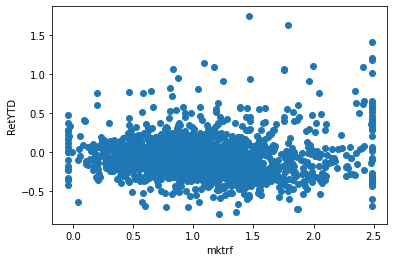

In [395]:
plt.scatter(x=Risk_data['mktrf'], y=Risk_data["RetYTD"])
plt.xlabel('mktrf')
plt.ylabel('RetYTD')

1. 'RetYTD' is concentrated between -0.5 and 0.5
2. the larger 'mktrf' is, the smaller the number of firms. there is no significant linear correlation between x and y

Text(0, 0.5, 'RetYTD')

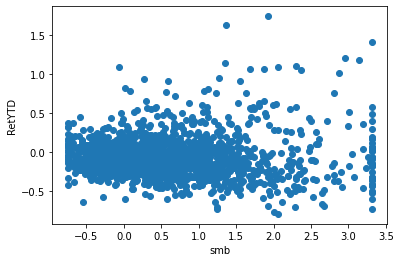

In [396]:
plt.scatter(x=Risk_data['smb'], y=Risk_data["RetYTD"])
plt.xlabel('smb')
plt.ylabel('RetYTD')

1. The higher the ‘smb’, the smaller the number of companies, but most of the ‘RetYTD’ are higher

2. Most companies have ‘smb’ below 1, and ‘RetYTD’ is concentrated between -0.5 and 0.5


Text(0, 0.5, 'RetYTD')

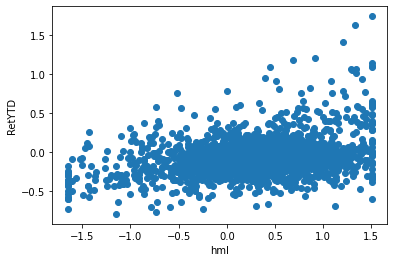

In [397]:
plt.scatter(x=Risk_data['hml'], y=Risk_data["RetYTD"])
plt.xlabel('hml')
plt.ylabel('RetYTD')

1. There is a certain positive relationship when 'RetYTD' is greater than 1.

2. 'hml' of the company is concentrated between -0.5 and 1


## Ratio Graphs

In [398]:
Financial_data.describe()

,RetYTD,Book/Price,E/P,EBIT/P,SALES/P,Total assets turnover,LT_Debit/Total_assets,ROA,RE/Total_Assets,NET PROFIT MARGIN,Market_Value/Book_Equity,SALES/PS
count,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000
mean,-0.063484,0.411311,0.028879,0.061057,0.756090,0.626616,0.280539,0.047144,-0.096974,-7.628432,4.160579,0.677420
std,0.243801,0.340396,0.101367,0.106257,1.408077,0.549811,0.244616,0.130723,1.315257,71.674009,8.776058,0.832963
min,-0.787400,-0.337273,-0.516577,-0.365760,-0.087004,0.000132,0.000000,-0.597211,-35.382839,-714.564516,-44.173250,0.000060
25%,-0.199450,0.160357,0.008159,0.019405,0.179004,0.185607,0.078514,0.018602,-0.083876,0.045584,1.460857,0.179004
50%,-0.086750,0.337783,0.036775,0.056386,0.352446,0.511923,0.256766,0.053231,0.084603,0.127945,2.678204,0.352446
75%,0.038750,0.608627,0.075836,0.113710,0.812176,0.900111,0.407980,0.106175,0.313861,0.265951,5.244947,0.812176
max,1.735700,1.366409,0.231730,0.329366,22.268447,2.370510,3.109857,0.298160,2.484373,0.673515,36.842451,3.972782


Text(0, 0.5, 'RetYTD')

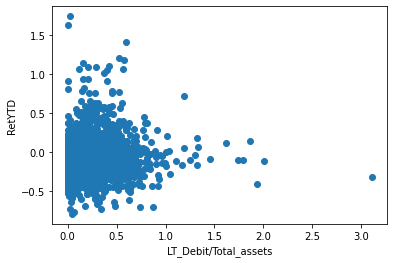

In [399]:
plt.scatter(x=Financial_data['LT_Debit/Total_assets'], y=Financial_data["RetYTD"])
plt.xlabel('LT_Debit/Total_assets')
plt.ylabel('RetYTD')

Text(0, 0.5, 'RetYTD')

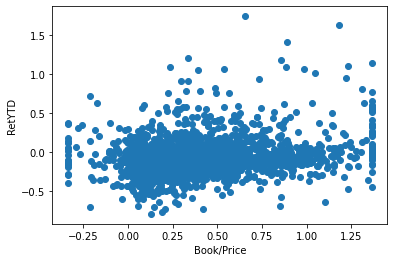

In [400]:
plt.scatter(x=Financial_data['Book/Price'], y=Financial_data["RetYTD"])
plt.xlabel('Book/Price')
plt.ylabel('RetYTD')

## Summary

In this project, I analyzed 1886 listed companies in three aspects to find out the factors affecting 'RetYTD'.

The first aspect is the analysis of Risk Exposures, based on the Fama-French Three-Factor Model, which will help us to determine the risk of stocks more accurately. The final OLS regression equation is not particularly satisfactory and the R2 is not statistically significant.

The second aspect is the analysis of some market ratio and financial ratio, these ratios mainly revolve around the company's liabilities, assets, net income and so on. Various dimensions are used to determine the risk resistance of a company. The final R2 is only about 10%, which is not statistically significant.

The third aspect I analyzed was from the industry perspective, where I wanted to see if the industry a company was in would have an impact on its stock. The final R2 obtained is around 32%, which is a very good result and is statistically significant. This indicates that industry has an effect on the market value of a company's stock, which is reasonable given the reality of the economy.

Combining the above three results together gives a regression model with an R2 of almost 40%, which is meaningful for predicting the 'RetYTD' of stocks. This side by side should also confirm the summary about coefficient in each regression equation.

## Recommandation
* Industry has the greatest correlation on 'RetYTD'
* Large stocks + high value is the least risky for an uncertain environment
* The Covid-19 and the Russo-Ukrainian war in early 2022 may have an impact on the results


## Further analysis
* Analyze the period when the economic and political situation was more stable and compare it with this result